In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import quandl as ql
import statsmodels.formula.api as smf
pd.set_option('display.float_format', lambda x: '%.9f' % x)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
ql.ApiConfig.api_key = os.getenv('quandl_key')

 # Return Forecasting:  Read Historical Daily Yen Futures Data from Quandl
 In this activity, you will pull historical Dollar-Yen exchange rate futures data from Quandl and test whether there is any predictable behavior using time-series models.

 * First, you'll need to download the futures data using the Quandl API, and return it as a Pandas DataFrame.
 * You'll need a Quandl API key (free): https://www.quandl.com/
 * (Use code "CHRIS/CME_JY1")
 * Trim the resulting data to include only from the the year 1990 through today.

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
fut = mydata = ql.get("CHRIS/CME_JY1")
fut.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.000000000,3401.000000000,3398.000000000,3401.000000000,nan,3401.000000000,2.000000000,1.000000000
1976-08-03,3401.000000000,3401.000000000,3401.000000000,3401.000000000,nan,3401.000000000,0.000000000,1.000000000
1976-08-04,3401.000000000,3401.000000000,3401.000000000,3401.000000000,nan,3401.000000000,0.000000000,1.000000000
1976-08-05,3401.000000000,3401.000000000,3401.000000000,3401.000000000,nan,3401.000000000,0.000000000,1.000000000
1976-08-06,3401.000000000,3401.000000000,3401.000000000,3401.000000000,nan,3401.000000000,0.000000000,1.000000000


In [3]:
# Trim the dataset to begin on January 1st, 1990
fut =  fut.loc['1990-01-01': :]
fut.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.000000000,6954.000000000,6835.000000000,6847.000000000,nan,6847.000000000,48336.000000000,51473.000000000
1990-01-03,6877.000000000,6910.000000000,6865.000000000,6887.000000000,nan,6887.000000000,38206.000000000,53860.000000000
1990-01-04,6937.000000000,7030.000000000,6924.000000000,7008.000000000,nan,7008.000000000,49649.000000000,55699.000000000
1990-01-05,6952.000000000,6985.000000000,6942.000000000,6950.000000000,nan,6950.000000000,29944.000000000,53111.000000000
1990-01-08,6936.000000000,6972.000000000,6936.000000000,6959.000000000,nan,6959.000000000,19763.000000000,52072.000000000


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

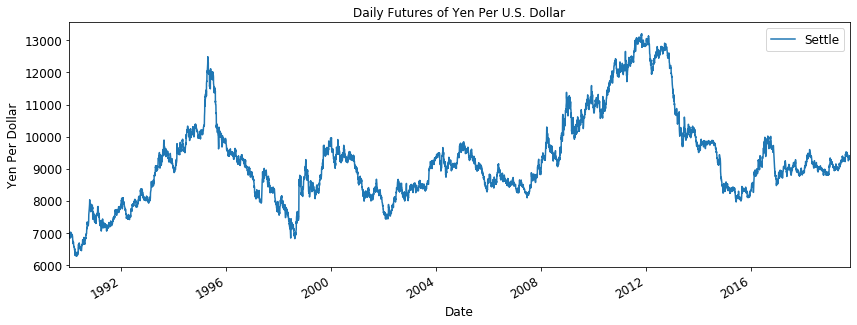

In [4]:
# Plot just the "Settle" column from the dataframe:
ax = fut.Settle.plot(legend = True, title = 'Daily Futures of Yen Per U.S. Dollar', figsize = (14,5), fontsize = 12)
ax.set_ylabel('Yen Per Dollar', fontsize = 12)
ax.set_xlabel('Date', fontsize = 12)
ax.legend(fontsize = 12)
plt.show()

 # Return Forecasting: MA/EWMA Smoothing of Futures Prices

 1. Plot the Settle Price, along with a moving average of 15 and 60 days. Use indexing to just plot the data from 2015 onward.
 2. What do you see now, in terms of short versus long-term trends?
 3. Try an exponential moving average, with a half life of 15 days.
 4. Which seems to respond faster, an exponential moving average with a half life of 15 days, or a moving average of 15 days?

 (15 days = 3 weeks)
 (60 days = 3 months)

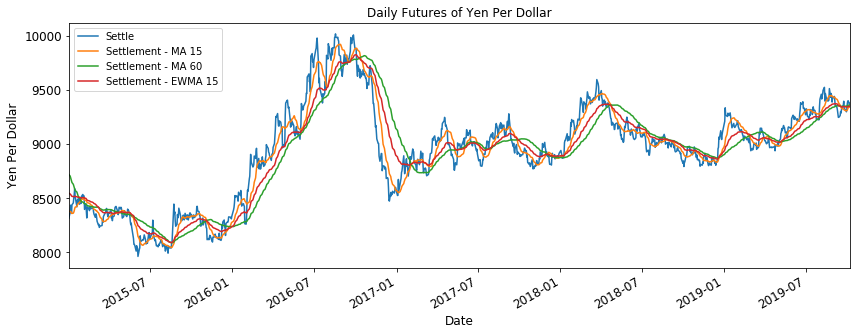

In [5]:
###### Moving averages and exponentially weighted moving averages 
# Create a dataframe using just the "Settle" price
df=fut[["Settle"]].copy()

# Add in columns for moving average windows of 15 and 60 days, and a column for an EWMA window of 15 days
df['Settlement - MA 15'] = df.Settle.rolling(window = 15).mean()
df['Settlement - MA 60'] = df.Settle.rolling(window = 60).mean()
df['Settlement - EWMA 15'] = df.Settle.ewm(halflife = 15).mean()

# Plot the settle price and moving average/ewma columns all in one plot from 2015:
ax = df["2015":].plot(figsize=(14,5), title = 'Daily Futures of Yen Per Dollar', fontsize = 12)
ax.set_ylabel('Yen Per Dollar', fontsize = 12)
ax.set_xlabel('Date', fontsize = 12)
plt.show()

# Return Forecasting: Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

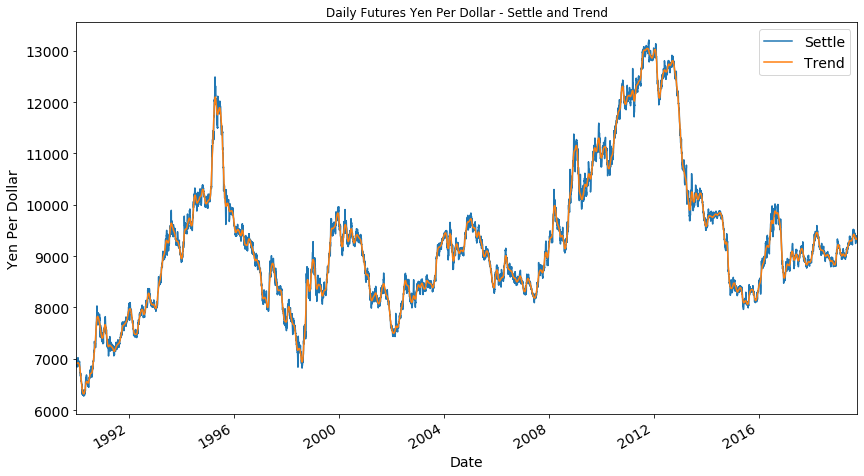

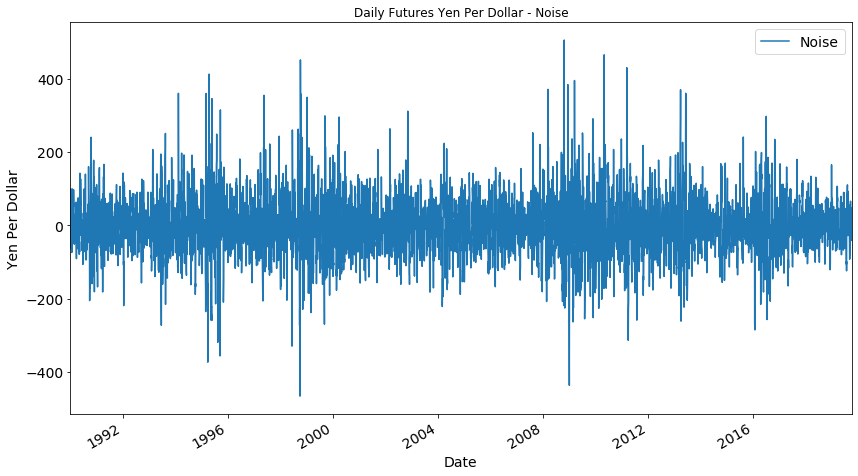

In [6]:
import statsmodels.api as sm
# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
ts_noise, ts_trend =  sm.tsa.filters.hpfilter(df['Settle'])

# Create a dataframe of just the settle price, and add in the "noise" and "trend" series from above:
futures_decomp = df[["Settle"]].copy()
futures_decomp["Noise"] =  ts_noise 
futures_decomp["Trend"] =  ts_trend 

# Plot the "Settle" and "Trend" price 
ax = futures_decomp.plot(y = ['Settle', 'Trend'], title ='Daily Futures Yen Per Dollar - Settle and Trend', figsize = (14,8), fontsize = 14)
ax.set_ylabel('Yen Per Dollar', fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
ax.legend(fontsize = 14)
plt.show()

# Then plot the "noise" separately
ax = futures_decomp.plot(y = 'Noise', title = 'Daily Futures Yen Per Dollar - Noise', figsize = (14,8), fontsize = 14)
ax.set_ylabel('Yen Per Dollar', fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
ax.legend(fontsize = 14)
plt.show()

 # Return Forecasting: Seasonal Effects with Sklearn Linear Regression
 Using the full dataset, use a SKLearn linear regression to predict Yen futures ("settle") returns with *lagged* Yen futures returns and categorical calendar seasonal effects (e.g., day-of-week or week-of-year seasonal effects).


In [7]:
#Use the dataframe containing "Settle" Prices:
fut.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.000000000,6954.000000000,6835.000000000,6847.000000000,nan,6847.000000000,48336.000000000,51473.000000000
1990-01-03,6877.000000000,6910.000000000,6865.000000000,6887.000000000,nan,6887.000000000,38206.000000000,53860.000000000
1990-01-04,6937.000000000,7030.000000000,6924.000000000,7008.000000000,nan,7008.000000000,49649.000000000,55699.000000000
1990-01-05,6952.000000000,6985.000000000,6942.000000000,6950.000000000,nan,6950.000000000,29944.000000000,53111.000000000
1990-01-08,6936.000000000,6972.000000000,6936.000000000,6959.000000000,nan,6959.000000000,19763.000000000,52072.000000000


In [8]:
from sklearn.linear_model import LinearRegression

# Construct a "Futures Return" column, using pandas pct_change() on the "Settle" price 
# If will be easier to also multiply this by 100, both to read and when we use it with SKLearn:
fut["Futures Return"] = fut["Settle"].copy().pct_change() * 100

# Feature Engineering
# Create a second "Lagged Return" variable, that is the futures return variable shifted above, but lagged 1 day:
# We"ll use this lagged return as the feature vector X:
fut["Lagged Return"] = fut['Futures Return'].shift()
fut = fut.replace(-np.inf, np.nan).dropna()

# Construct a new "X" dataframe using just the "Lagged Return" variable:
X = fut["Lagged Return"].to_frame()

In [9]:
# Add into the X dataframe either a "dayofweek" or "weekofyear" column, (e.g., using X.index.weekofyear) 
X["Week of Year"] = X.index.weekofyear

# Create a new categorical X dataframe, by using pd.get_dummies() on the seasonal column created just above:
X_binary_encoded = pd.get_dummies(X, columns =['Week of Year'])
X_binary_encoded.head()

,Lagged Return,Week of Year_1,Week of Year_2,Week of Year_3,Week of Year_4,Week of Year_5,Week of Year_6,Week of Year_7,Week of Year_8,Week of Year_9,...,Week of Year_44,Week of Year_45,Week of Year_46,Week of Year_47,Week of Year_48,Week of Year_49,Week of Year_50,Week of Year_51,Week of Year_52,Week of Year_53
Date,,,,,,,,,,,,,,,,,,,,,
2014-02-18,0.409123453,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2014-02-19,-0.427829276,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2014-02-20,-0.020460358,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2014-02-21,0.020464545,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2014-02-24,-0.204603581,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Create a "y" series, using just the "Futures Return" column created above.
y = fut["Futures Return"].copy()

# Construct a "LinearRegression" object:
model = LinearRegression()

# Fit a model using the X and y objects:
results = model.fit(X_binary_encoded, y)


In [11]:
# Construct predictions based on the X object:
predictions = results.predict(X_binary_encoded)
predictions

array([-0.09338379, -0.0539856 , -0.07315063, ..., -0.0519104 ,
        0.09390259,  0.11444092])

 Summarize the quality of your model using R2 and root-mean-squared-error (RMSE) statistics. How good is it?

In [12]:
from sklearn.metrics import mean_squared_error, r2_score
# Calculate r2_score (r-squared)
r2 = r2_score(y, predictions) 

# Calculate mean squared error 
# (A "good" MSE score will be close to zero while a "good" R2 Score will be close to 1.)
mse = mean_squared_error(y, predictions)

# Using mean squared eror above, calculate root-mean-squared error (RMSE)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Standard Deviation of Futures Return: {y.std()}")

Mean Squared Error (MSE): 0.2833059955870231
R-squared (R2 ): 0.049389539001399085
Root Mean Squared Error (RMSE): 0.5322649674617174
Standard Deviation of Futures Return: 0.546110652432277


 #### Plotting and Independent (X) Variable Interpretation

 Plot the model predictions of returns against actual returns, for just data from 2018 onward.

In [13]:
# Create a "y" dataframe, using just the "Futures Return" column created above. 
y_df = y.to_frame()

# Add the model predictions from above as an additional column to that dataframe:
y_df["prediction"] =  predictions
y_df.head()


,Futures Return,prediction
Date,,
2014-02-18,-0.427829276,-0.093383789
2014-02-19,-0.020460358,-0.053985596
2014-02-20,0.020464545,-0.073150635
2014-02-21,-0.204603581,-0.075103760
2014-02-24,0.020502307,-0.066619873


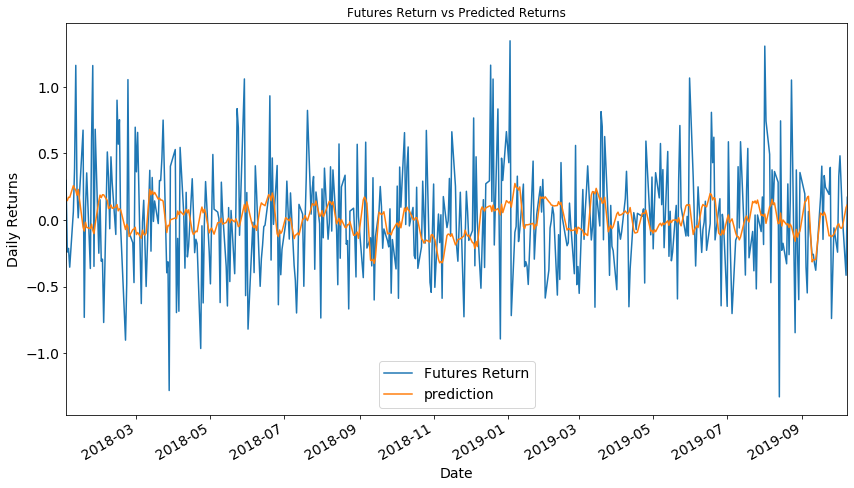

In [14]:
# Plot the two from 2018 onward
ax = y_df.loc['2018-01-01' : :].plot(title = 'Futures Return vs Predicted Returns', fontsize = 14, figsize = (14,8))
ax.legend(fontsize = 14)
ax.set_ylabel('Daily Returns', fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
plt.show()

 Separately, plot the calendar effects estimated from the model using matplotlib. Do you see any seasonal patterns?

In [15]:
# Construct a dataframe of the model calendar-effect coefficients and review the output:
results = pd.DataFrame(model.coef_, columns=["Coefficient"], index=X_binary_encoded.columns)

# Filter results so that it only includes either the day-of-week or week-of-year effect 
results = (results[results.index.str.contains("Week of Year")])

results.head(10)


,Coefficient
Week of Year_1,-150050133186.058746338
Week of Year_2,-150050133185.977416992
Week of Year_3,-150050133186.269561768
Week of Year_4,-150050133186.266326904
Week of Year_5,-150050133186.042999268
Week of Year_6,-150050133186.108337402
Week of Year_7,-150050133186.107147217
Week of Year_8,-150050133186.292633057
Week of Year_9,-150050133186.294738770
Week of Year_10,-150050133186.324279785


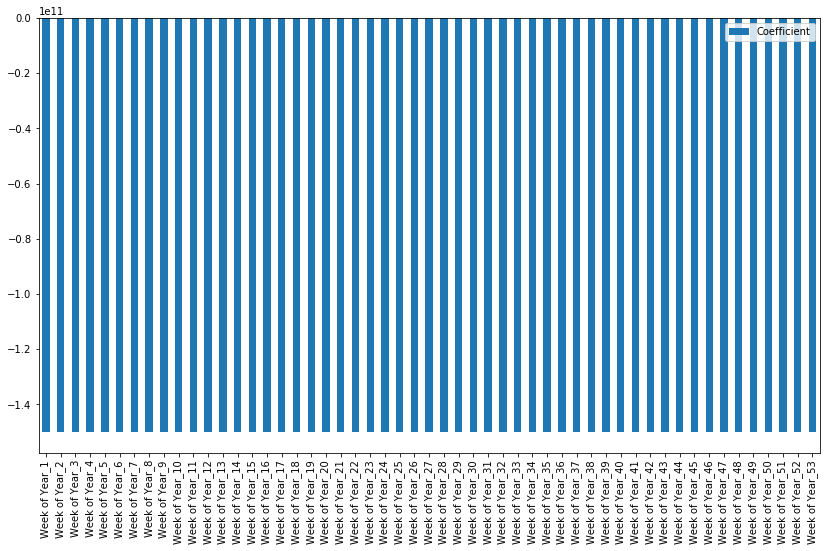

In [16]:
# Plot the results of the individual seasonal effects using pandas df.plot()
results.plot(kind = 'bar', figsize = (14,8)) 

 # Return Forecasting: Autocorrelation and the ARMA Model

 Using futures Settle *Returns*, estimate an ARMA model.
 1. Set the AR and MA ("p" and "q") parameters to p=2 and q=1.
 2. Plot autocorrelation and partial correlation graphs with an alpha of 0.10 and lags=30. If, when looking at the correlation graphs, additional lags seem important for predicting returns, increase the number of lags in the ARMA model from (1).
 3. Does increasing the number of "p" or "q" increase the ability of the model? Compare your results between the two models by comparing the Bayseian Information Criterion, or BIC.

In [17]:
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm

# Create a series using "Settle" price percentage returns, and drop any nan's:
df = fut[["Settle"]].pct_change().dropna()

# Estimate and ARMA model using statsmodels
# Hint: ARMA(df, order=(p, q)).fit()
autoregressive_count = 2
moving_average_window = 1
model = ARMA(df, order =(autoregressive_count,moving_average_window))
results = model.fit()


In [18]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Settle   No. Observations:                 1409
Model:                     ARMA(2, 1)   Log Likelihood                5343.551
Method:                       css-mle   S.D. of innovations              0.005
Date:                Wed, 09 Oct 2019   AIC                         -10677.102
Time:                        10:16:07   BIC                         -10650.848
Sample:                             0   HQIC                        -10667.291
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.479e-05      0.000     -0.097      0.923      -0.000       0.000
ar.L1.Settle     0.3012      0.342      0.882      0.378      -0.368       0.971
ar.L2.Settle     0.0461      0.027      1.732      0.084      -0.006       0.098
ma.L1.Settle    -0.3148      0.341     -0.922      0.357      -0.984       0.354
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.4225           +0.0000j            2.4225            0.0000
AR.2           -8.9622           +0.0000j            8.9622            0.5000
MA.1            3.1770           +0.0000j            3.1770            0.0000
-----------------------------------------------------------------------------
"""

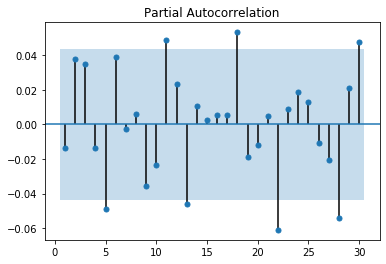

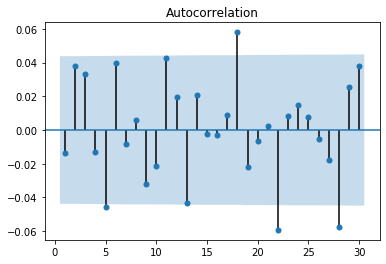

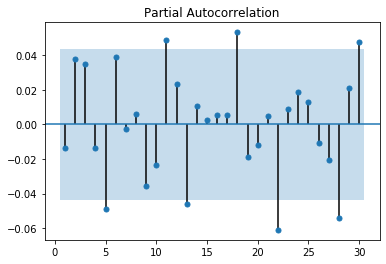

In [19]:
# Plot autocorrelation and partial correlation graphs with an alpha of 0.10 and lags=30.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Autocorrelation (For detecting # of MA ("P") Lags)
plot_acf(df, alpha = 0.10, lags = 30, zero = False) 

# Partial Autocorrelation (For detecting # of MA ("P") Lags)
plot_pacf(df, alpha = 0.10, lags = 30, zero = False)

In [20]:
autoregressive_count = 17
moving_average_window = 6

# Esimate your model based on your interpretation of the autocorrelation/partial autocorrelation plots:
model = ARMA(df, order =(autoregressive_count, moving_average_window))
results = model.fit()
# Review model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Settle   No. Observations:                 1409
Model:                    ARMA(17, 6)   Log Likelihood                5357.909
Method:                       css-mle   S.D. of innovations              0.005
Date:                Wed, 09 Oct 2019   AIC                         -10665.818
Time:                        10:22:12   BIC                         -10534.552
Sample:                             0   HQIC                        -10616.763
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.353e-05      0.000     -0.088      0.930      -0.000       0.000
ar.L1.Settle      0.1744      0.421      0.414      0.679      -0.651       1.000
ar.L2.Settle     -0.0105      0.200     -0.052      0.958      -0.402       0.381
ar.L3.Settle     -0.0851      0.140     -0.609      0.543      -0.359       0.189
ar.L4.Settle     -0.2431      0.142     -1.711      0.087      -0.522       0.035
ar.L5.Settle     -0.5432      0.165     -3.291      0.001      -0.867      -0.220
ar.L6.Settle      0.6197      0.396      1.566      0.118      -0.156       1.396
ar.L7.Settle      0.0273      0.039      0.706      0.480      -0.048       0.103
ar.L8.Settle     -0.0101      0.042     -0.242      0.809      -0.092       0.072
ar.L9.Settle     -0.0741      0.037     -2.016      0.044      -0.146      -0.002
ar.L10.Settle    -0.0210      0.043     -0.493      0.622      -0.104       0.062
ar.L11.Settle     0.1010      0.045      2.259      0.024       0.013       0.189
ar.L12.Settle    -0.0202      0.053     -0.382      0.702      -0.124       0.083
ar.L13.Settle    -0.0438      0.025     -1.784      0.075      -0.092       0.004
ar.L14.Settle    -0.0099      0.030     -0.331      0.740      -0.068       0.049
ar.L15.Settle     0.0249      0.030      0.822      0.411      -0.035       0.084
ar.L16.Settle     0.0284      0.025      1.140      0.254      -0.020       0.077
ar.L17.Settle     0.0144      0.035      0.411      0.681      -0.054       0.083
ma.L1.Settle     -0.1866      0.421     -0.443      0.658      -1.012       0.639
ma.L2.Settle      0.0621      0.193      0.322      0.748      -0.316       0.440
ma.L3.Settle      0.1101      0.157      0.703      0.482      -0.197       0.417
ma.L4.Settle      0.2272      0.163      1.392      0.164      -0.093       0.547
ma.L5.Settle      0.5062      0.172      2.951      0.003       0.170       0.843
ma.L6.Settle     -0.5698      0.385     -1.482      0.139      -1.324       0.184
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             0.6973           -0.7710j            1.0395           -0.1330
AR.2             0.6973           +0.7710j            1.0395            0.1330
AR.3             1.2149           -0.0000j            1.2149           -0.0000
AR.4             1.1536           -0.4814j            1.2500           -0.0629
AR.5             1.1536           +0.4814j            1.2500            0.0629
AR.6             0.6532           -1.0144j            1.2065           -0.1590
AR.7             0.6532           +1.0144j            1.2065            0.1590
AR.8            -0.4685           -0.9570j            1.0656           -0.3225
AR.9            -0.4685           +0.9570j            1.0656            0.3225


 # Return Forecasting: Deploying the ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags

 2. Plot the residuals from the model. If residuals are the part of returns that our model *doesn"t* explain, does it seem like our model has missed any seasonality?
 3. Construct a 15 day (3 week) forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [37]:
# For ARIMA, construct a dataframe using just the futures "Settle" prices:
df = fut[['Settle']]
df.head()

,Settle
Date,
2014-02-18,9775.000000000
2014-02-19,9773.000000000
2014-02-20,9775.000000000
2014-02-21,9755.000000000
2014-02-24,9757.000000000


                             ARIMA Model Results                              
Dep. Variable:               D.Settle   No. Observations:                 1409
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -7484.527
Method:                       css-mle   S.D. of innovations             49.058
Date:                Wed, 09 Oct 2019   AIC                          14985.054
Time:                        10:23:37   BIC                          15027.059
Sample:                             1   HQIC                         15000.751
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.2858      1.333     -0.214      0.830      -2.899       2.327
ar.L1.D.Settle    -0.5924      0.315     -1.878      0.061      -1.211       0.026
ar.L2.D.Settle     0.0389      0.031

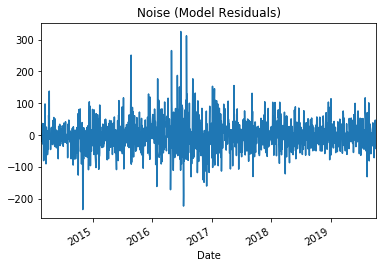

count   1409.000000000
mean       0.001172049
std       49.074983733
min     -234.130821528
25%      -27.681208581
50%       -0.778284699
75%       25.406674614
max      325.291371121
dtype: float64


In [38]:
from statsmodels.tsa.arima_model import ARIMA
# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model = ARIMA(df, order =(5, 1, 1))
model_fit = model.fit()
# Output model summary results:
print(model_fit.summary())
# plot residual errors:
residuals = model_fit.resid
residuals.plot(title="Noise (Model Residuals)")
plt.show()
print(residuals.describe())


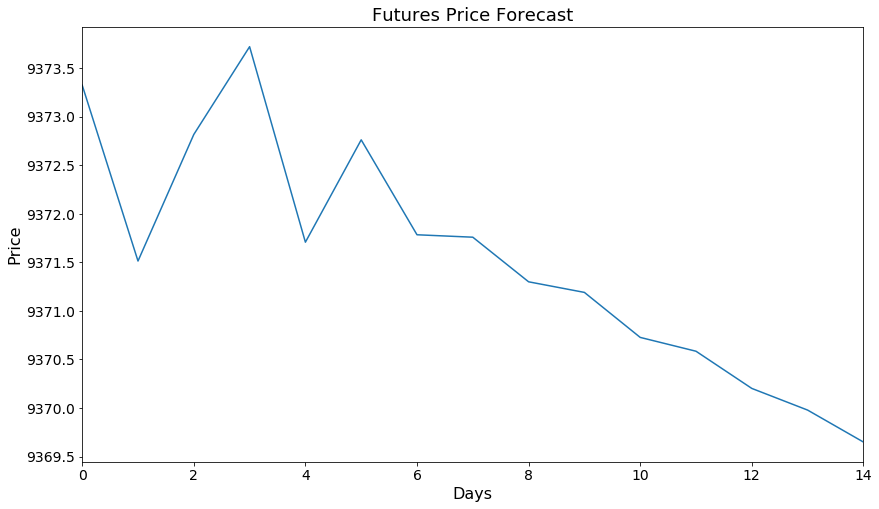

In [23]:
# Construct a 15 day (3 week) forecast for the Settle Price. 
# What does the model forecast will happen to the Japanese Yen in the near term?
# Specifically, construct a pandas DataFrame containing ARIMA model forecasts for a 15-day window:
ax = pd.DataFrame(model_fit.forecast(steps = 15)[0]).plot(fontsize = 14, figsize = (14,8), legend = False)
ax.set_xlabel('Days', fontsize = 16)
ax.set_title('Futures Price Forecast',fontsize = 18)
ax.set_ylabel('Price', fontsize = 16)
plt.show()

 # Volatility Forecasting

 Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.

### Volatility Forecasting: GARCH and EGARCH Models
Using the "arch" package, estimate either GARCH(1,1) or an EGARCH(p,q) volatility forecast model on futures settle returns.

In [24]:
import arch as arch
from arch import arch_model

In [25]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by *100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns=(fut[["Settle"]].pct_change()*100)
returns=returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-02,0.482392668
2019-10-03,0.256040967
2019-10-04,0.021282256
2019-10-07,-0.414915687
2019-10-08,0.170931040


In [26]:
# Estimate a GARCH(1,1) model using the "arch" package:
# (We need to drop all NaN"s first in order to get this to run):
am = arch_model(returns, mean = 'Zero', vol = 'GARCH', p = 1, q = 1)
res = am.fit(disp = 'off')

In [27]:
# Output the summary results of the GARCH model:
print(res.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -1066.61
Distribution:                  Normal   AIC:                           2139.21
Method:            Maximum Likelihood   BIC:                           2154.97
                                        No. Observations:                 1409
Date:                Wed, Oct 09 2019   Df Residuals:                     1406
Time:                        10:22:52   Df Model:                            3
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      2.3941e-03  1.693e-03      1.414      0.157 

### Volatility Forecasting: Identifying Patterns of Clustered Volatility

GARCH/EGARCH, etc. models are good for capturing the "volatility clustering" effect that is common in financial data. After estimating your model, can you identify periods when volatility clusters together?

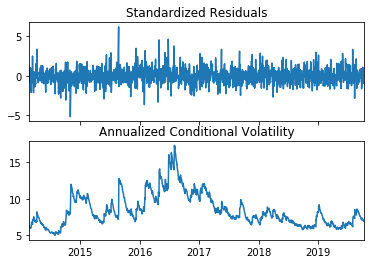

In [28]:
# Plot the model"s conditional volatility for the Yen:
# Hint: use .plot(annualize="D")
fig = res.plot(annualize = 'D')

### Volatility Forecasting: 3-day Yen Volatility Forecasts using GARCH/EGARCH
  * Let's do some forecasting of near-term risk. Specifically, use the .forecast() method to calculate 3-day forecasts. Then plot the resulting 3-day annualized variance. Is Yen volatility expected to rise or fall in the near term?

In [29]:
# Note--You can either specify today"s date manually, or use pd.datetime.today().strftime("%Y-%m-%d") 
# (example format: start="2019-06-28")
# If you have problems with datetime, 
# specify data date manually using the most recent trading date in the dataframe
#todays_date = pd.datetime.today().strftime("%Y-%m-%d")                  
todays_date = '2019-10-02'
# Forecast volatility, from today"s date until the following three days:
forecast_horizon = 3
forecasts = res.forecast(start = todays_date, horizon = forecast_horizon)
forecasts

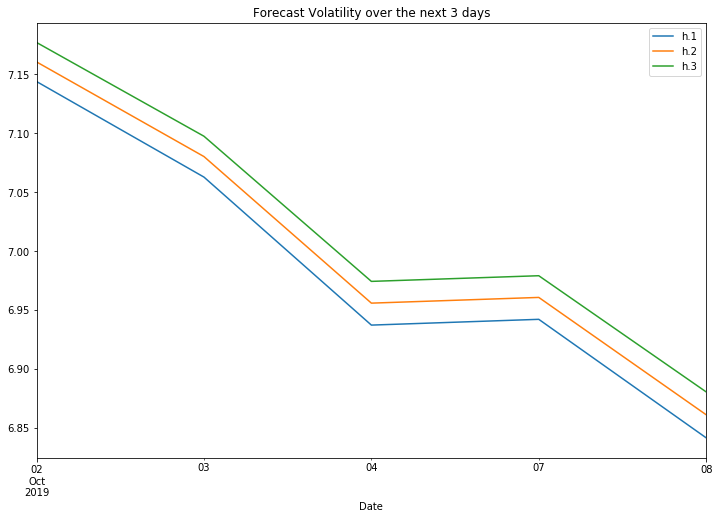

In [39]:
# Plot the annualized volatility forecast using pd.plot():
# (Make sure to use dropna() on the forecasts before plotting):
# (There are 252 trading days in a year)
# Note: each column in forecasts.variance represents one day ahead: 
plot_title = f"Forecast Volatility over the next {forecast_horizon} days"
model_forecasts = np.sqrt(forecasts.variance.dropna() * 252) 
model_forecasts.dropna().plot(title=plot_title, figsize = (12, 8)) 

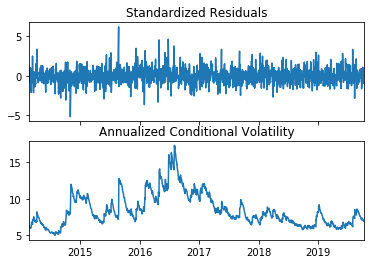

In [31]:
fig = res.plot(annualize = 'D')

 # Out-of-Sample Predictions
 So far, you"ve used the full dataset to construct a model. Let's try a more rigorous technique.

### Out-of-Sample Predictions: Slicing the Data into Training and Test Set ("One Shot" Approach)

Using the SKLearn regression model and just lagged returns as the independent variable, start by estimating a model using **training data** from January, 2015 through December 2017.

In [32]:
# If you haven"t already, create and add "Futures Return" and "Lagged Futures Return" variables to your dataframe:
# Replace inf, -inf with np.nan, then drop any row with at least one np.nan in the dataframe
#fut["Futures Return"] = 
#fut["Lagged Return"] = # YOUR CODE HERE 
#fut = fut.replace(-np.inf, np.nan).dropna()
fut[["Futures Return", "Lagged Return"]].head()

,Futures Return,Lagged Return
Date,,
2014-02-18,-0.427829276,0.409123453
2014-02-19,-0.020460358,-0.427829276
2014-02-20,0.020464545,-0.020460358
2014-02-21,-0.204603581,0.020464545
2014-02-24,0.020502307,-0.204603581


In [33]:
# Using datetime index slicing, create a "training" data dataframe using data from just 2015-01-01 to 2017-12-31
train = fut.loc['2015-01-01':'2017-12-31']
print("Training set covers from ", train.index.min(), " to ", train.index.max())
train.head(2)

Training set covers from  2015-01-02 00:00:00  to  2017-12-29 00:00:00


,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Futures Return,Lagged Return
Date,,,,,,,,,,
2015-01-02,8352.000000000,8353.000000000,8286.000000000,8310.000000000,34.000000000,8315.000000000,101438.000000000,222022.000000000,-0.407234399,-0.262812089
2015-01-05,8305.000000000,8382.000000000,8293.000000000,8371.000000000,56.000000000,8371.000000000,165487.000000000,226085.000000000,0.673481660,-0.407234399


In [34]:
# Using datetime index slicing, create a "test" data dataframe using data from 2018-01-01 through the end of the data
test = fut.loc['2018-01-01': :]
print("Test set covers from ", test.index.min(), " to ", test.index.max())
test.head(2)

Test set covers from  2018-01-02 00:00:00  to  2019-10-08 00:00:00


,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Futures Return,Lagged Return
Date,,,,,,,,,,
2018-01-02,8909.500000000,8957.500000000,8898.500000000,8938.000000000,26.500000000,8940.500000000,96714.000000000,227884.000000000,0.297285169,0.224870699
2018-01-03,8943.000000000,8947.500000000,8913.000000000,8921.000000000,21.500000000,8919.000000000,93498.000000000,226582.000000000,-0.240478720,0.297285169


  * Then use the model developed on a test set using data from 2018 onward.

In [35]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train['Lagged Return'].to_frame()
y_train = train['Futures Return'].to_frame() 
X_test = test['Lagged Return'].to_frame()
y_test = test['Futures Return'].to_frame()

In [49]:
# Fit a SKLearn linear regression using  just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

# Score how that model works using only the test data
model.score(X_test, y_test)

# And make a prediction of "y" values for just the test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test
#Results["Predicted Return"] = predictions
Results['Predicted Returns'] = predictions


In [50]:
Results.head()

,Futures Return,Predicted Returns
Date,,
2018-01-02,0.297285169,0.004079729
2018-01-03,-0.240478720,0.001856820
2018-01-04,-0.213028366,0.018364575
2018-01-05,-0.353932584,0.017521930
2018-01-08,0.062017252,0.021847271



  * Compare the RMSE from the model using the test sample to the RMSE when using the full-sample. Are the results surprising?

In [52]:
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
# (Hint: use the dataframe above)
mse = mean_squared_error(Results['Futures Return'], Results['Predicted Returns'])

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
one_shot_rmse = np.sqrt(mse) 
print(f"Out-of-Sample Mean Squared Error (MSE): {mse}")
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {one_shot_rmse}")

Out-of-Sample Mean Squared Error (MSE): 0.1718870180293033
Out-of-Sample Root Mean Squared Error (RMSE): 0.4145925928297602


In [53]:
# Construct a dataframe using just the "y" training data:
in_sample_results = y_train

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results["In-sample Predictions"] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(in_sample_results['Futures Return'], in_sample_results['In-sample Predictions'])

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse) 
print(f"In-sample Mean Squared Error (MSE): {in_sample_mse}")
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

In-sample Mean Squared Error (MSE): 0.39156536290427835
In-sample Root Mean Squared Error (RMSE): 0.6257518381149818


### Out-of-Sample Predictions: The Rolling Out-of-Sample Approach

Let's take the model above (i.e., SKLearn predicting futures returns with lagged futures returns), but apply it using a rolling, out of sample approach. This method, which is specific to time-series predictions, will be a more realistic and more rigorous approximation of how the model would perform in real life.

Specifically, start at the beginning of the dataset and "roll forward" one week at a time, using a 26-week (6 month) rolling training window.

In [ ]:
# Main Idea: Each week, re-estimate the model, then trade on it the following week. 
# Continue this "out of sample" approach throughout the dataset.

In [54]:
# Construct an empty placeholder dataframe, with a column named "Out-of-Sample Predictions"
# (Each iteration of the loop, we"ll append that week"s predictions to this DataFrame)
all_predictions = pd.DataFrame(columns=["Out-of-Sample Predictions"])
# Construct an empty placeholder dataframe, with a column named "Actual Returns"
# (Each iteration of the loop, we"ll append that week"s predictions to this DataFrame)
all_actuals = pd.DataFrame(columns=["Actual Returns"])

# construct a list of all pandas weekly periods that are in the dataset:
weeks = fut.index.to_period("w").unique()

# Specify a training window (26 weeks (6 months) of data)
training_window = 26 
timeframe = len(weeks) - training_window - 1

for i in range(0, timeframe):
    
    # Beginning of training window
    start_of_training_period = weeks[i].start_time.strftime(format="%Y-%m-%d")
    
    # End of training window
    end_of_training_period = weeks[training_window + i].end_time.strftime(format="%Y-%m-%d")

    # Window of test-window data
    test_week = weeks[training_window+i+1]
    
    # String of testing window
    start_of_test_week  = test_week.start_time.strftime(format="%Y-%m-%d")
    end_of_test_week = test_week.end_time.strftime(format="%Y-%m-%d")
    
    train = fut[start_of_training_period:end_of_training_period]
    test = fut[start_of_test_week:end_of_test_week]
    
    # Create new dataframes:
    X_train = train["Lagged Return"].to_frame()
    y_train = train["Futures Return"]
    X_test = test["Lagged Return"].to_frame()
    y_test = test["Futures Return"]

    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    # Create a temporary dataframe to hold predictions
    predictions = pd.DataFrame(predictions, index=X_test.index, columns=["Out-of-Sample Predictions"])
    # Create a temporary DataFrame of the actual "y"s in the test dataframe, with column name="Actual Returns": 
    actuals = pd.DataFrame(y_test, index=y_test.index)
    actuals.columns = ["Actual Returns"]  
    # Append these two dataframes (predictions and actuals) to the two master DataFrames built outside the loop
    all_predictions = all_predictions.append(predictions)
    all_actuals = all_actuals.append(actuals)



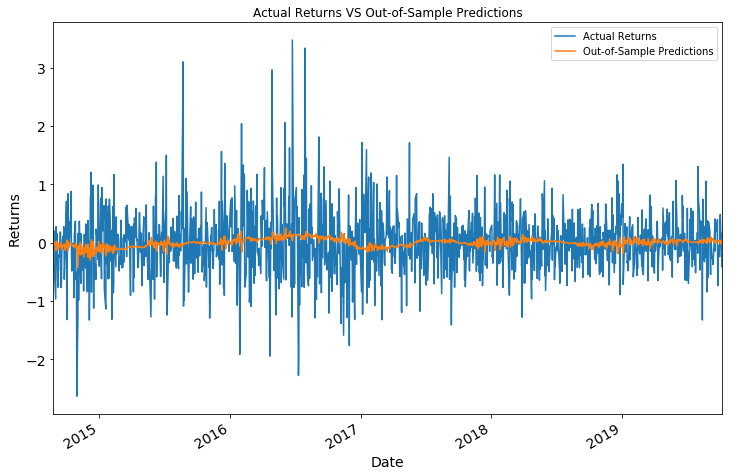

In [55]:
# Plot the results:
Results = pd.concat([all_actuals, all_predictions], axis=1)
ax = Results.plot(title = 'Actual Returns VS Out-of-Sample Predictions', fontsize = 14, figsize = (12,8))
ax.set_ylabel('Returns', fontsize = 14) 
ax.set_xlabel('Date', fontsize = 14)
plt.show()

  * Evaluate the model RMSE.
      * Which has the better RMSE--this more robust method, or the single ("one-shot") training and test split just above?

In [56]:
# Calculate the mean_squared_error on the Results DataFrame:
# (This compares the average (squared) difference between actual and model-predicted returns)
rolling_mse = mean_squared_error(Results['Actual Returns'], Results['Out-of-Sample Predictions'])
# Then use that to calculate the Root-Mean-Squared Error (RMSE):
rolling_rmse = np.sqrt(mse)
print(f"Out-of-Sample Mean Squared Error (MSE): {rolling_mse}")
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rolling_rmse}")

Out-of-Sample Mean Squared Error (MSE): 0.3215423335884435
Out-of-Sample Root Mean Squared Error (RMSE): 0.4145925928297602


In [ ]:
# Compare the RMSE from the training-testing single split versus the rolling out-of-sample approach we just did:


Challenge: Can you calculate the out-of-sample R2? Based on this, should we bet money on this model?

In [ ]:
# YOUR CODE HERE 